In [ ]:
import kagglehub

# Download and get the local dataset path (unzip if necessary)
dataset_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/blood-cells


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset directory
DATA_DIR = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images'
train_dir = os.path.join(DATA_DIR, 'TRAIN')
test_dir = os.path.join(DATA_DIR, 'TEST')

Using device: cuda


In [ ]:

# Define classes
classes = sorted(os.listdir(train_dir))
print("Classes:", classes)

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load datasets
full_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(train_dir, transform=val_transform)

# Train-Validation Split
indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[full_dataset.targets[i] for i in indices], random_state=42)

train_data = Subset(full_dataset, train_idx)
val_data = Subset(val_dataset, val_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:
# Load pre-trained VGG16
vgg = models.vgg16(pretrained=True)

# Freeze early layers (optional)
for param in vgg.features.parameters():
    param.requires_grad = False

# Modify classifier for our number of classes
vgg.classifier[6] = nn.Linear(4096, len(classes))

vgg = vgg.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 93.5MB/s]


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    vgg.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_losses.append(val_loss / len(val_loader))
    print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10: 100%|██████████| 249/249 [01:42<00:00,  2.42it/s]


Train Loss: 1.0577, Val Loss: 0.8115, Val Acc: 0.6421


Epoch 2/10: 100%|██████████| 249/249 [01:17<00:00,  3.20it/s]


Train Loss: 0.6524, Val Loss: 0.4492, Val Acc: 0.8278


Epoch 3/10: 100%|██████████| 249/249 [01:16<00:00,  3.23it/s]


Train Loss: 0.4799, Val Loss: 0.3448, Val Acc: 0.8640


Epoch 4/10: 100%|██████████| 249/249 [01:18<00:00,  3.19it/s]


Train Loss: 0.3777, Val Loss: 0.2989, Val Acc: 0.8805


Epoch 5/10: 100%|██████████| 249/249 [01:17<00:00,  3.23it/s]


Train Loss: 0.3094, Val Loss: 0.2730, Val Acc: 0.8850


Epoch 6/10: 100%|██████████| 249/249 [01:17<00:00,  3.20it/s]


Train Loss: 0.2941, Val Loss: 0.2227, Val Acc: 0.9041


Epoch 7/10: 100%|██████████| 249/249 [01:17<00:00,  3.22it/s]


Train Loss: 0.2362, Val Loss: 0.2935, Val Acc: 0.8715


Epoch 8/10: 100%|██████████| 249/249 [01:17<00:00,  3.22it/s]


Train Loss: 0.2141, Val Loss: 0.2097, Val Acc: 0.9111


Epoch 9/10: 100%|██████████| 249/249 [01:17<00:00,  3.20it/s]


Train Loss: 0.2028, Val Loss: 0.1719, Val Acc: 0.9302


Epoch 10/10: 100%|██████████| 249/249 [01:17<00:00,  3.21it/s]


Train Loss: 0.1807, Val Loss: 0.1593, Val Acc: 0.9347


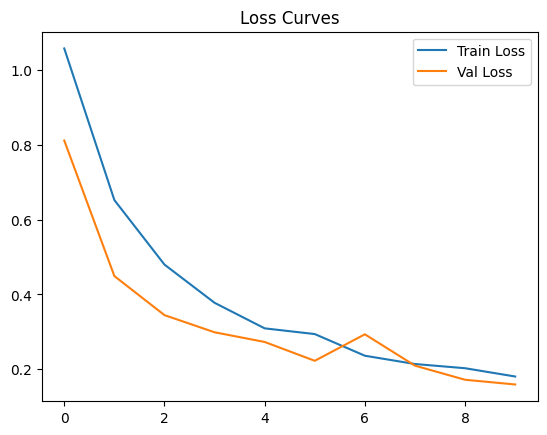

Classification Report:
               precision    recall  f1-score   support

  EOSINOPHIL       0.89      0.90      0.90       499
  LYMPHOCYTE       1.00      0.94      0.97       497
    MONOCYTE       0.97      1.00      0.98       496
  NEUTROPHIL       0.88      0.90      0.89       500

    accuracy                           0.93      1992
   macro avg       0.94      0.93      0.94      1992
weighted avg       0.94      0.93      0.93      1992



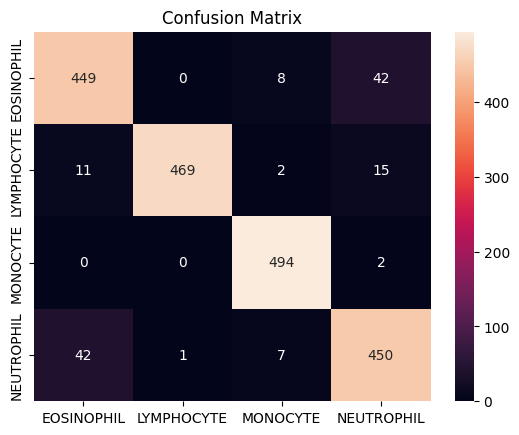

In [ ]:
# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

# Evaluation
vgg.eval()
y_true = []
y_pred = []

for images, labels in val_loader:
    images = images.to(device)
    outputs = vgg(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, xticklabels=classes, yticklabels=classes, fmt='d')
plt.title("Confusion Matrix")
plt.show()
